## Image processing using the Fast Fourier Transform

In this section, we have a glance at how the Fast Fourier Transform (FFT) can be used to process images. The FFT is a powerful tool for analyzing the frequency content of signals, including images. By transforming an image into the frequency domain, we can manipulate its frequency components to achieve various effects, such as filtering, compression, and enhancement.

The examples below are taken and adapted from [git](https://github.com/dynamicslab/databook_python), see in particular the examples 
[CH02_SEC06_2_Compress.ipynb](https://github.com/dynamicslab/databook_python/blob/master/CH02/CH02_SEC06_2_Compress.ipynb)
and
[CH02_SEC06_3_Denoise.ipynb](https://github.com/dynamicslab/databook_python/blob/master/CH02/CH02_SEC06_3_Denoise.ipynb).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.fft import fft2, ifft2, fftfreq, fftshift


We can load images stored in jpeg or png format directly from the filesystem using the `imread` function from `matplotlib.image`. 
This function takes the path to the image file as an argument and returns a NumPy array representing the image.

When a color image is loaded, the resulting array has three dimensions: 
* **height**: the number of pixel rows in the image
* **width**: the number of pixel columns in the image
* **color**: channels: the number of color channels (3 for RGB images)

<img src="color_image_array.png" alt="Images as 3D array" width="500"/>


For digital images using the Red-Green-Blue (RGB) color model,
the color of a single pixel is represented by a vector like [R, G, B], 
where R, G, and B are typically integers in the range [0, 255]:

* R = Red intensity
* G = Green intensity
* B = Blue intensity

Each component is typically an integer between 0 and 255 (8-bit unsigned integer), where:
* 0 means no intensity of that color
* 255 means maximum intensity

The final color seen at that pixel is a mix of the red, green, and blue light in the specified intensities.

Examples:
* [255, 0, 0] → Pure Red
* [0, 255, 0] → Pure Green
* [0, 0, 255] → Pure Blue
* [255, 255, 255] → White (full intensity of all colors)
* [0, 0, 0] → Black (no color/light)
* [128, 128, 128] → Gray (equal parts of R, G, B)

For grayscale images, the array has two dimensions (height, width), with each pixel represented by a single intensity value ranging from 0 (black) to 255 (white).

Let's load an image using the `imread` function from
`matplotlib.image` submodule and display it using
`matplotlib.pyplot.imshow` function, once as original image and then
with only one channel activated at a time.

In [2]:
dogimage = imread('dog.jpg').copy()
print(dogimage.shape)
print(dogimage.min())
print(dogimage.max())


(2000, 1500, 3)
0
255


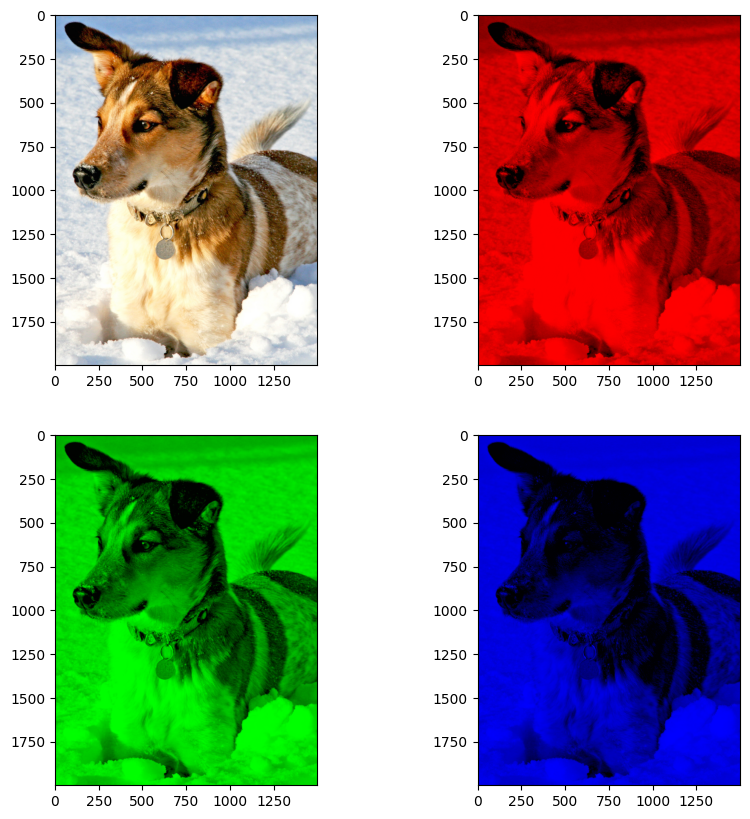

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dogimage, cmap='gray')

dogimage_red = dogimage.copy()
dogimage_red[:, :, [1,2]] = 0
ax[0,1].imshow(dogimage_red)

dogimage_green = dogimage.copy()
dogimage_green[:, :, [0,2]] = 0
ax[1,0].imshow(dogimage_green)

dogimage_blue = dogimage.copy()
dogimage_blue[:, :, [0,1]] = 0
ax[1,1].imshow(dogimage_blue)
plt.show()


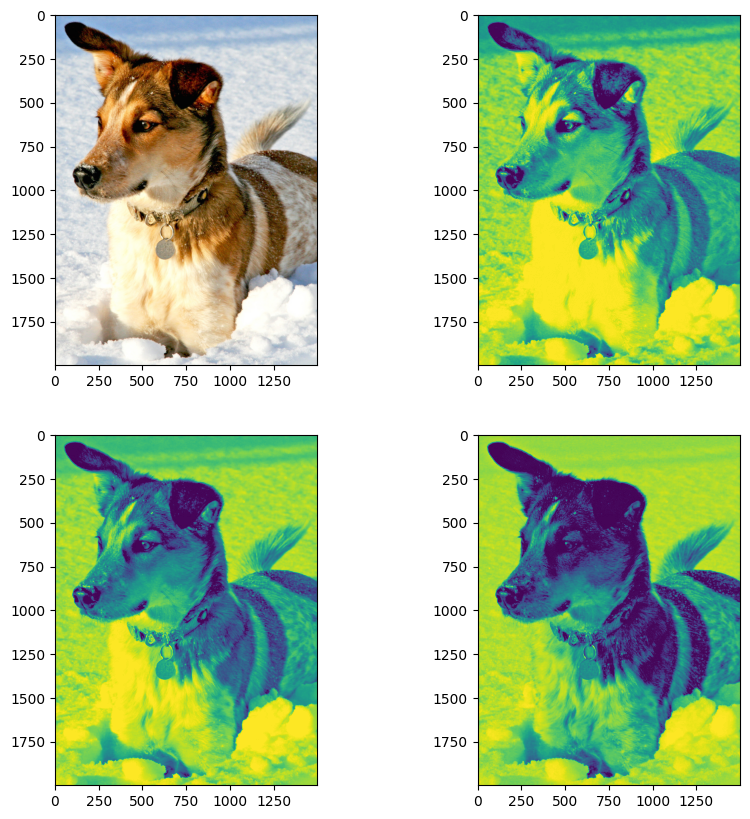

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(dogimage)

ax[0,1].imshow(dogimage[:,:,0])
ax[1,0].imshow(dogimage[:,:,1])
ax[1,1].imshow(dogimage[:,:,2])
plt.show()


Now we turn the image into a gray scale image by simply taking the average of the three channels. This results in a 2D array of shape (height, width) instead of a 3D array of shape (height, width, 3). The resulting image is a gray scale image where each pixel is represented by a single value between 0 and 255. The value 0 represents black and the value 255 represents white. The values in between represent different shades of gray.

When you plotting the image, you must tell `imshow` that the image is gray scale by passing the `cmap` argument with the value `gray`. The `cmap` argument is short for color map. The default value is `viridis`, which is a color map that is perceptually uniform and works well for most applications. However, when displaying gray scale images, we want to use a different color map.

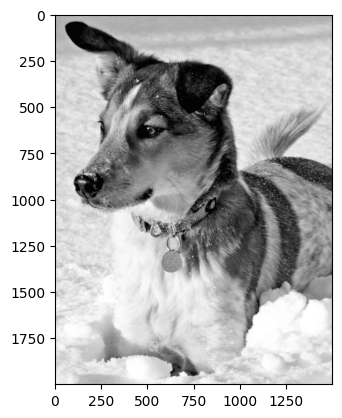

In [8]:
doggray = np.mean(dogimage, axis=2)
plt.imshow(doggray, cmap='gray')
plt.show()


### Compressing grayscale images using the FFT
Let us illustrate how to use the FFT to compress a grayscale image.

In [9]:
doggray_hat = fft2(doggray)
# Sort by magnitude to determine the most significant frequencies
doggray_hat_sort = np.sort(np.abs(doggray_hat.flatten()))


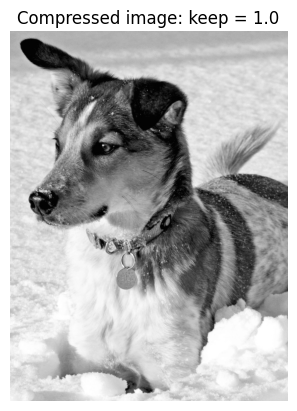

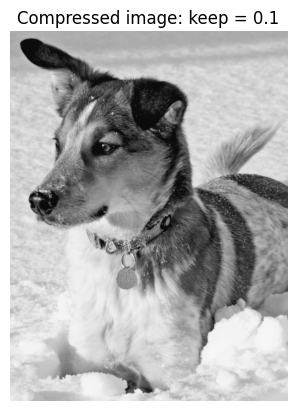

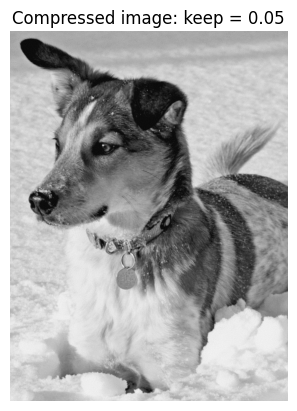

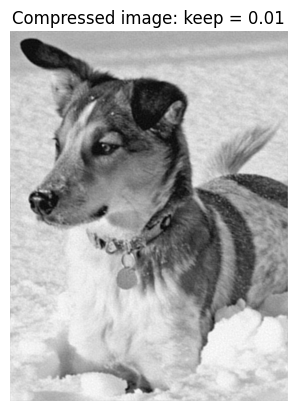

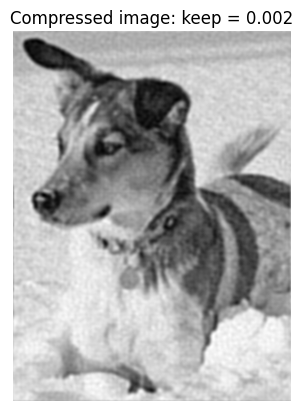

In [11]:
# Zero out all small coefficients and inverse transform
import math
keep_ratios  = (1.0, 0.1, 0.05, 0.01, 0.002)

for i in range(len(keep_ratios)):
    keep = keep_ratios[i]
    thresh = doggray_hat_sort[int(np.floor((1-keep)*len(doggray_hat_sort)))]
    ind = np.abs(doggray_hat)>thresh          # Find small indices
    Atlow = doggray_hat * ind                 # Threshold small indices
    Alow = np.fft.ifft2(Atlow).real  # Compressed image
    plt.figure()
    plt.imshow(Alow,cmap='gray')
    plt.axis('off')
    plt.title('Compressed image: keep = ' + str(keep))
plt.show()


### A simple denoising example using the FFT

We illustrate how to use the FFT to denoise a grayscale image.
First, we add some noise to the image. The noise is generated using a standard normal distribution with a mean of 0 and variance of 1. 
The noise is then added to the original image, resulting in a noisy image.

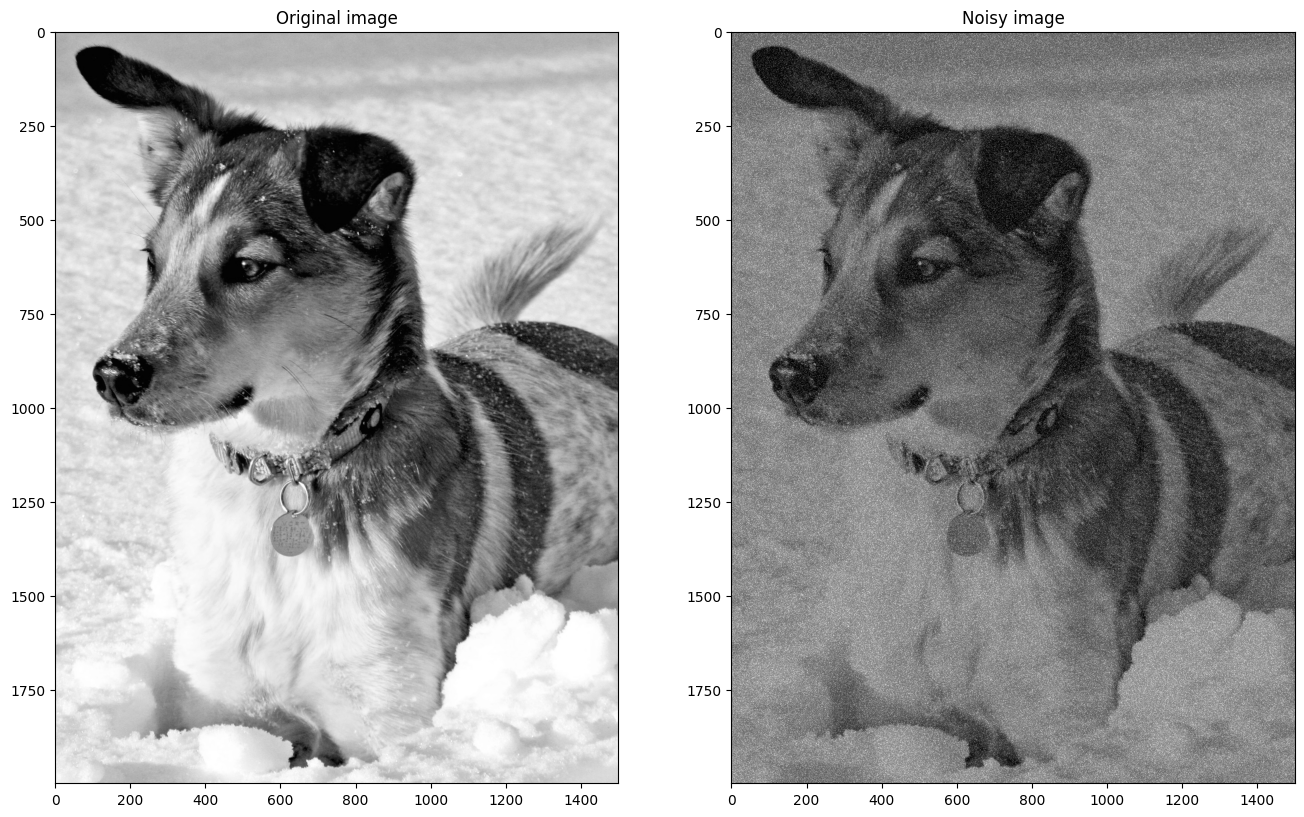

In [13]:
B = np.mean(dogimage, -1); # Convert RGB to grayscale

## Add some noise
Bnoise = B + 200*np.random.randn(*B.shape).astype('uint8') # Add some noise
fig,axs = plt.subplots(1,2,figsize=(16,16))
axs[0].imshow(B,cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(Bnoise,cmap='gray')
axs[1].set_title('Noisy image')
plt.show()


Let's try to see how their respective Fourier transforms look like.

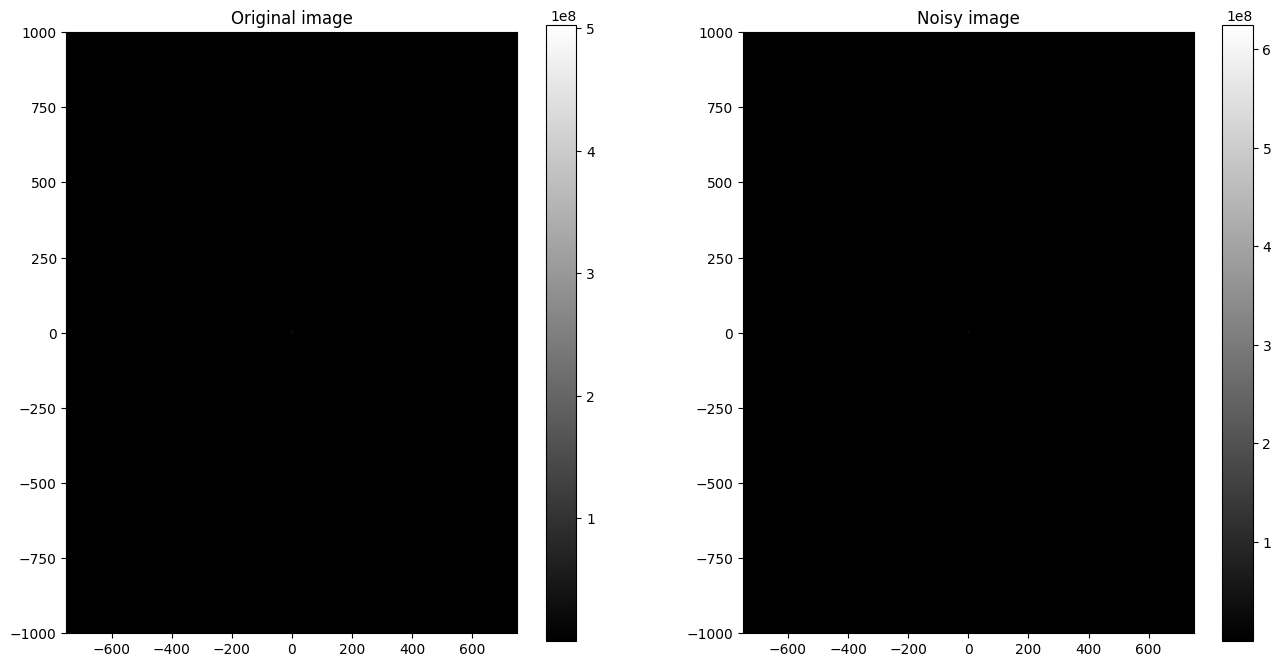

In [15]:
Bhat_shift = fftshift(fft2(B)) # FFT of image
Bnoisehat_shift = fftshift(fft2(Bnoise)) # FFT of noisy image
ny,nx = B.shape

fig,axs = plt.subplots(1,2,figsize=(16,16))
img0 = axs[0].imshow(np.abs(Bhat_shift),cmap='gray',
                     extent=(-nx/2,nx/2,-ny/2,ny/2))
axs[0].set_title('Original image')
fig.colorbar(img0, orientation='vertical', shrink=0.5)

img1 = axs[1].imshow(np.abs(Bnoisehat_shift),cmap='gray',
                        extent=(-nx/2,nx/2,-ny/2,ny/2))
axs[1].set_title('Noisy image')
fig.colorbar(img1, orientation='vertical', shrink=0.5)
plt.show()


This was not very helpful! Indeed, large parts of the image's information are concentrated in low frequencies, which are hard to see on a linear scale. Using a logarithmic scale makes low frequencies more visible.

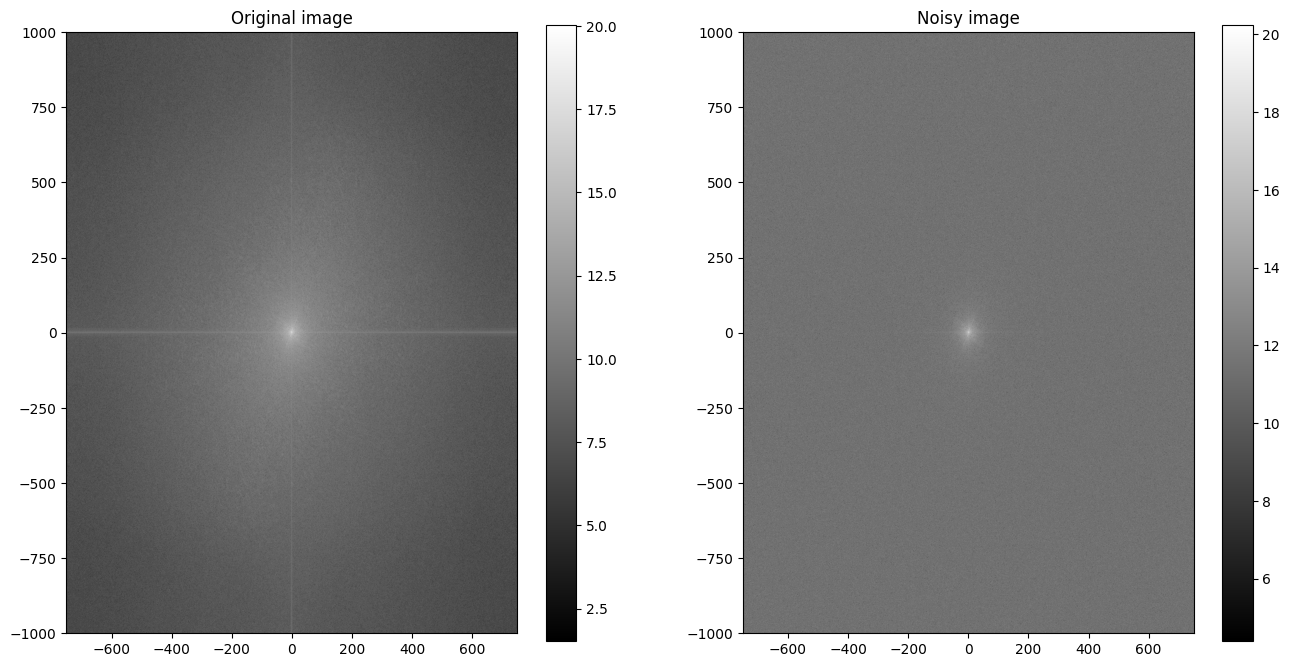

In [16]:
log_Bhat_shift = np.log(1 + np.abs(Bhat_shift))
log_Bnoisehat_shift = np.log(1 + np.abs(Bnoisehat_shift))
ny,nx = B.shape

fig,axs = plt.subplots(1,2,figsize=(16,16))
img0 = axs[0].imshow(log_Bhat_shift,cmap='gray',
                     extent=(-nx/2,nx/2,-ny/2,ny/2))
axs[0].set_title('Original image')
# axs[0].axis('off')
fig.colorbar(img0, orientation='vertical', shrink=0.5)

img1 = axs[1].imshow(log_Bnoisehat_shift,cmap='gray',
                     extent=(-nx/2,nx/2,-ny/2,ny/2))
axs[1].set_title('Noisy image')
# axs[1].axis('off')
fig.colorbar(img1, orientation='vertical', shrink=0.5)
plt.show()


We see that most of the information  is concentrated in the low frequencies,
as their amplitudes are significantly larger than those of the high frequencies.
We also see that adding noise to the image has added high frequency components to the Fourier transform.
A simple filtering technique is to remove the high frequency components from the Fourier transform of the noisy image by using a threshold frequency, thus zeroing out the high frequencies.

In the code below, we simply neglect all gradients above a certain threshold frequency $f_{\mathrm{tres}} = 150$.

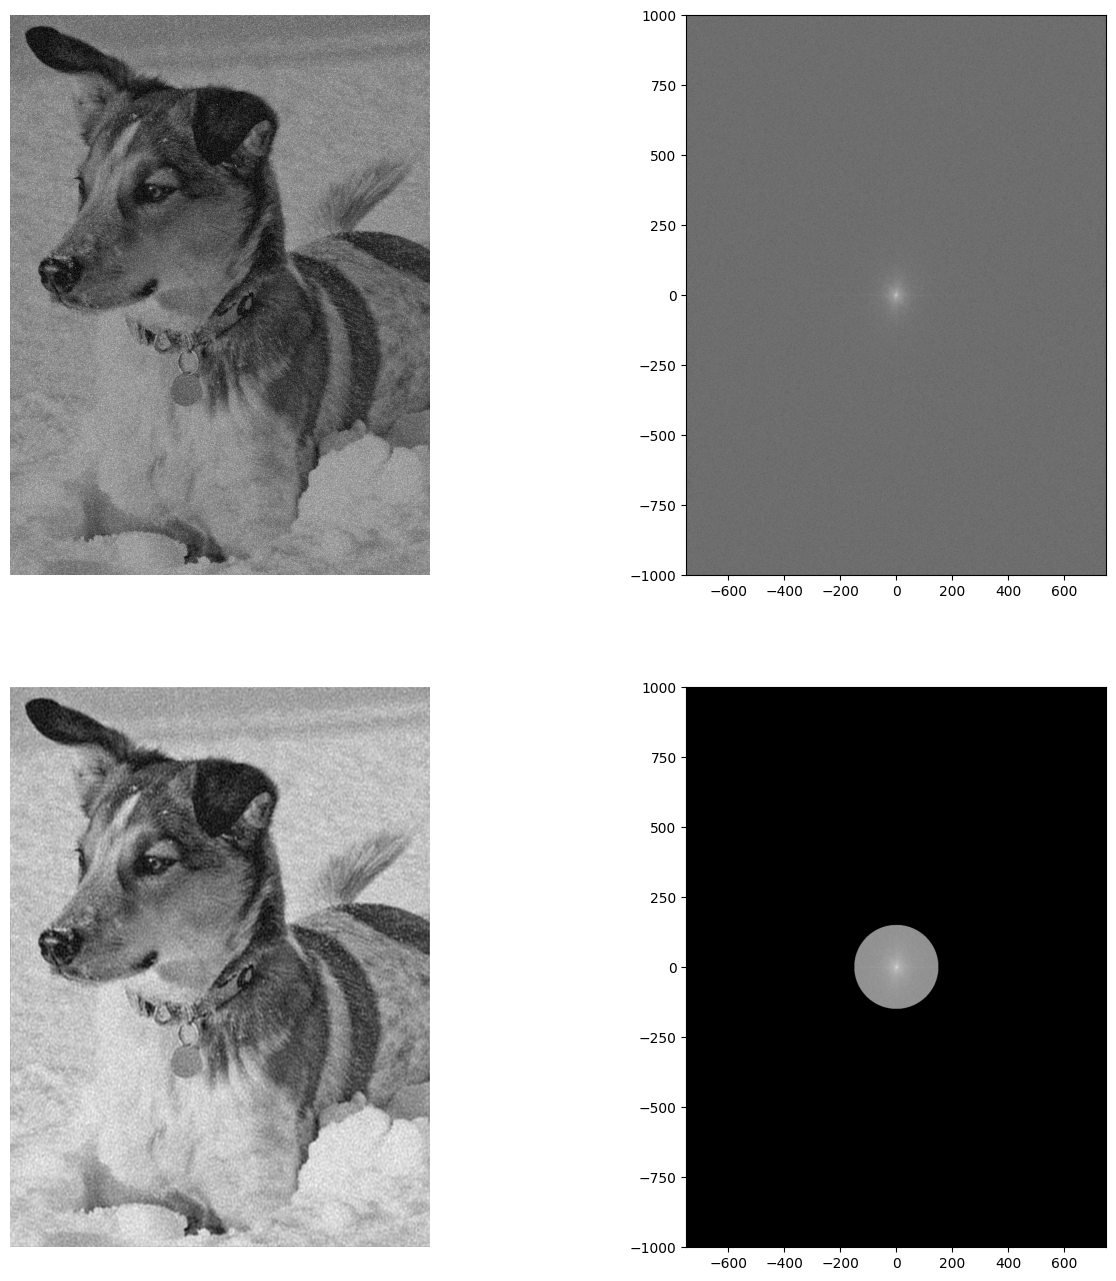

In [17]:
B = np.mean(dogimage, -1); # Convert RGB to grayscale

## Denoise
Bnoise = B + 200*np.random.randn(*B.shape).astype('uint8') # Add some noise
Bt = np.fft.fft2(Bnoise)
Btshift = np.fft.fftshift(Bt)

F = np.log(np.abs(Btshift)+1) # Put FFT on log scale

fig,axs = plt.subplots(2,2,figsize=(16,16))

axs[0,0].imshow(Bnoise,cmap='gray')
axs[0,0].axis('off')

axs[0,1].imshow(F,cmap='gray',
                     extent=(-nx/2,nx/2,-ny/2,ny/2))

ny,nx = B.shape
X,Y = np.meshgrid(np.arange(-nx/2+1,nx/2+1),np.arange(-ny/2+1,ny/2+1))
# xgrid = np.fft.ifftshift(np.arange(-nx/2+1,nx/2+1))
# ygrid = np.fft.ifftshift(np.arange(-ny/2+1,ny/2+1))
# X,Y = np.meshgrid(ygrid,xgrid)
R2 = np.power(X,2) + np.power(Y,2)
ind = R2 < 150**2
Btshiftfilt = Btshift * ind
Ffilt = np.log(np.abs(Btshiftfilt)+1) # Put FFT on log scale

axs[1,1].imshow(Ffilt,cmap='gray',
                     extent=(-nx/2,nx/2,-ny/2,ny/2))

Btfilt = np.fft.ifftshift(Btshiftfilt)
Bfilt = np.fft.ifft2(Btfilt).real
axs[1,0].imshow(Bfilt,cmap='gray')
axs[1,0].axis('off')

plt.show()

We want to stress that the shown examples/techniques are quite simplistic and  mainly presented for educational purposes, that is, to give you an idea where/how the FFT can be used in image processing.
Of course, there are many, many more sophisticated techniques for image compression and denoising, such as windowed Fourier transform,  wavelet transforms, principal component analysis (PCA), and deep learning-based methods which we cannot cover here.